# Decoding with Key-Value Cache

Lecture 9 | CMU ANLP Spring 2026 | Instructor: Sean Welleck

This notebook shows key-value (KV) caching for transformer language models.

### Motivation

During autoregressive generation, transformers generate tokens one at a time:
- Token 1: Compute attention for token 1
- Token 2: Compute attention for tokens 1-2
- Token 3: Compute attention for tokens 1-3
- ...

**Problem**: Without caching, we recompute the keys and values for all previous tokens at each step.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings
warnings.filterwarnings('ignore')

### Transformer Block with Optional KV Cache

In [ ]:
class BlockWithCache(nn.Module):
    """Transformer block with optional key-value caching."""
    
    def __init__(self, d_model, nhead, dim_ff=64, max_len=128):
        super().__init__()
        assert d_model % nhead == 0
        
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)
        
        self.ff1 = nn.Linear(d_model, dim_ff)
        self.ff2 = nn.Linear(dim_ff, d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.act = nn.ReLU()
        
        self.cache_k = None
        self.cache_v = None
        
    def forward(self, x, use_cache=False):
        B, T, D = x.size()
        
        x_norm = self.ln1(x)
        
        Q = self.q_proj(x_norm)
        
        if use_cache and self.cache_k is not None:
            # Only compute K, V for the new token(s)
            K_new = self.k_proj(x_norm)
            V_new = self.v_proj(x_norm)
            
            # Append to cache
            K = torch.cat([self.cache_k, K_new], dim=1)
            V = torch.cat([self.cache_v, V_new], dim=1)
            
            # Update cache
            self.cache_k = K
            self.cache_v = V
            
        else:
            # Compute K, V for all tokens
            K = self.k_proj(x_norm)
            V = self.v_proj(x_norm)
            
            if use_cache:
                # Initialize cache
                self.cache_k = K
                self.cache_v = V
            
        # Reshape for multi-head attention
        T_k = K.size(1)  # Total sequence length including cache
        Q = Q.view(B, T, self.nhead, self.d_k).transpose(1, 2)
        K = K.view(B, T_k, self.nhead, self.d_k).transpose(1, 2)
        V = V.view(B, T_k, self.nhead, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        
        # Apply causal mask
        if T == 1 and use_cache:
            # During generation with cache, we only process single token
            pass  # No mask needed for single token with cache
        else:
            # During initial forward pass or without cache
            mask = torch.triu(torch.ones(T, T_k, device=x.device), diagonal=1 + (T_k - T)).bool()
            scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        
        # Apply softmax and compute weighted values
        attn_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)
        
        # Reshape and project output
        context = context.transpose(1, 2).contiguous().view(B, T, D)
        output = self.o_proj(context)
        
        # Residual connection
        x = x + output
        
        # Feed-forward with residual
        x_norm = self.ln2(x)
        ff_out = self.ff2(self.act(self.ff1(x_norm)))
        x = x + ff_out
        
        return x
    
    def clear_cache(self):
        """Clear the key-value cache."""
        self.cache_k = None
        self.cache_v = None

## Transformer Language Model

In [ ]:
class TransformerLM(nn.Module):
    """Transformer Language Model with optional caching."""
    
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_ff, max_len=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_len, d_model)
        self.blocks = nn.ModuleList([
            BlockWithCache(d_model, nhead, dim_ff, max_len) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)
        self.d_model = d_model
        self.max_len = max_len

    def forward(self, x, use_cache=False, past_length=0):
        B, T = x.size()
        
        pos = torch.arange(past_length, past_length + T, device=x.device)
        pos = pos.unsqueeze(0).expand(B, -1)
        
        x = self.embedding(x) + self.pos_encoder(pos)
        
        for block in self.blocks:
            x = block(x, use_cache=use_cache)
        
        x = self.ln_f(x)
        logits = self.fc(x)
        
        return logits
    
    def clear_cache(self):
        """Clear cache in all blocks."""
        for block in self.blocks:
            block.clear_cache()
    
    @torch.no_grad()
    def generate(self, context, max_length=20, temperature=1.0, use_cache=True):
        """Generate text with optional caching."""
        self.eval()
        self.clear_cache()
        
        # Start with context
        if len(context) == 0:
            context = [0]  # Start token
        
        generated = context.copy()
        
        for i in range(max_length):
            if use_cache and i > 0:
                # With cache: only process the new token
                x = torch.tensor([[generated[-1]]], dtype=torch.long)
                past_length = len(generated) - 1
            else:
                # Without cache or first iteration: process all tokens
                x = torch.tensor([generated], dtype=torch.long)
                past_length = 0
            
            # Get predictions
            logits = self(x, use_cache=use_cache, past_length=past_length)
            logits = logits[0, -1] / temperature
            
            # Sample next token
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            
            generated.append(next_token)
        
        return generated

## Create Model

In [4]:
# Create model with random weights (no training needed for demonstration)
vocab_size = 100
model = TransformerLM(
    vocab_size=vocab_size,
    d_model=64,
    nhead=4,
    num_layers=16,
    dim_ff=128,
    max_len=512
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Model parameters: 581348


## Performance Comparison

In [5]:
def compare_generation(model, context=[], max_length=20):
    """Compare generation with and without cache."""
    
    # Generate WITHOUT cache
    model.clear_cache()
    start_time = time()
    generated_no_cache = model.generate(context, max_length=max_length, use_cache=False)
    time_no_cache = time() - start_time
    
    # Generate WITH cache
    model.clear_cache()
    start_time = time()
    generated_with_cache = model.generate(context, max_length=max_length, use_cache=True)
    time_with_cache = time() - start_time
    
    print(f"Sequence length: {max_length}")
    print(f"\nWithout Cache:")
    print(f"  Time: {time_no_cache:.4f}s")
    print(f"\nWith Cache:")
    print(f"  Time: {time_with_cache:.4f}s")
    print(f"\nSpeedup: {time_no_cache/time_with_cache:.2f}x")

# Test with different lengths
compare_generation(model, context=[], max_length=512)

Sequence length: 512

Without Cache:
  Time: 5.6287s

With Cache:
  Time: 0.8062s

Speedup: 6.98x


## Generation Time Scaling

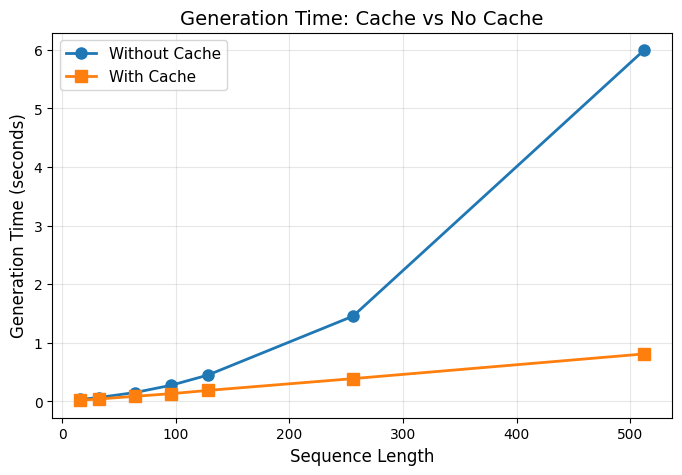


Speedup factors:
  Length 16: 1.61x
  Length 32: 1.57x
  Length 64: 1.73x
  Length 96: 2.08x
  Length 128: 2.38x
  Length 256: 3.73x
  Length 512: 7.39x


In [6]:
def benchmark_generation_time(model):
    """Benchmark generation time at different sequence lengths."""
    lengths = [16, 32, 64, 96, 128, 256, 512]
    times_no_cache = []
    times_with_cache = []
    
    for length in lengths:
        # Without cache
        model.clear_cache()
        start = time()
        _ = model.generate([], max_length=length, use_cache=False)
        times_no_cache.append(time() - start)
        
        # With cache
        model.clear_cache()
        start = time()
        _ = model.generate([], max_length=length, use_cache=True)
        times_with_cache.append(time() - start)
    
    return lengths, times_no_cache, times_with_cache

lengths, t_no_cache, t_cache = benchmark_generation_time(model)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(lengths, t_no_cache, 'o-', label='Without Cache', linewidth=2, markersize=8)
plt.plot(lengths, t_cache, 's-', label='With Cache', linewidth=2, markersize=8)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Generation Time (seconds)', fontsize=12)
plt.title('Generation Time: Cache vs No Cache', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Print speedup factors
print("\nSpeedup factors:")
for l, t1, t2 in zip(lengths, t_no_cache, t_cache):
    speedup = t1/t2
    print(f"  Length {l}: {speedup:.2f}x")